In [75]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
pd.set_option('display.max_columns', None)
# import the required classes and definitions from Python-MIP
from mip import Model, xsum, maximize, BINARY, INTEGER

In [117]:
raw = pd.read_csv('top500histories', index_col=0)
top500_raw = pd.read_csv('top500.csv')

In [118]:
raw.columns

Index(['assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'element',
       'fixture', 'goals_conceded', 'goals_scored', 'ict_index', 'influence',
       'kickoff_time', 'minutes', 'opponent_team', 'own_goals',
       'penalties_missed', 'penalties_saved', 'red_cards', 'round', 'saves',
       'selected', 'team_a_score', 'team_h_score', 'threat', 'total_points',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'was_home', 'yellow_cards', 'id_', 'web_name', 'team', 'sum_minutes',
       'sum_points', 'next_week_points', 'team_a_conceded_rank',
       'team_a_conceded_rank_next', 'points_per_90'],
      dtype='object')

In [119]:
 df = top500_raw[['id_', 'web_name', 'team', 'element_type', 'assists', 'bonus', 'bps', 'clean_sheets', 
                 'goals_scored', 'minutes', 'saves', 'total_points',
                 'transfers_in', 'transfers_out']]

In [120]:
histories = raw[['id_', 'web_name', 'value', 'assists', 'bonus', 'bps', 'clean_sheets', 'goals_scored', 
                 'minutes', 'round', 'saves', 'selected', 'total_points',
                 'team_a_score', 'team_h_score', 'transfers_in',
                 'transfers_out', 'sum_points', 'sum_minutes', 'team_a_conceded_rank', 'team_a_conceded_rank_next',
                 'points_per_90', 'next_week_points']]

In [121]:
for gameweek in range(1, max(histories['round'])):
    round_points = histories[histories['round'] == gameweek][['id_', 'total_points']] 
    df = df.merge(round_points, on='id_', how='left', suffixes=('', '_' + str(gameweek)))
for gameweek in range(1, max(histories['round'])):    
    round_value = histories[histories['round'] == gameweek][['id_', 'value']].rename(columns={'value':'value_' + str(gameweek)})
    df = df.merge(round_value, on='id_', how='left')
for gameweek in range(1, max(histories['round'])):    
    round_minutes = histories[histories['round'] == gameweek][['id_', 'minutes']].rename(columns={'minutes':'minutes_' + str(gameweek)})
    df = df.merge(round_minutes, on='id_', how='left')

In [122]:
df = df.fillna(0)

In [123]:
df.head(40)

,id_,web_name,team,element_type,assists,bonus,bps,clean_sheets,goals_scored,minutes,saves,total_points,transfers_in,transfers_out,total_points_1,total_points_2,total_points_3,total_points_4,total_points_5,total_points_6,total_points_7,total_points_8,total_points_9,total_points_10,total_points_11,total_points_12,total_points_13,total_points_14,total_points_15,total_points_16,total_points_17,total_points_18,total_points_19,total_points_20,total_points_21,total_points_22,total_points_23,value_1,value_2,value_3,value_4,value_5,value_6,value_7,value_8,value_9,value_10,value_11,value_12,value_13,value_14,value_15,value_16,value_17,value_18,value_19,value_20,value_21,value_22,value_23,minutes_1,minutes_2,minutes_3,minutes_4,minutes_5,minutes_6,minutes_7,minutes_8,minutes_9,minutes_10,minutes_11,minutes_12,minutes_13,minutes_14,minutes_15,minutes_16,minutes_17,minutes_18,minutes_19,minutes_20,minutes_21,minutes_22,minutes_23
0,215,De Bruyne,11,3,17,20,652,10,7,1890,0,159,4807143,2432472,7.0,11.0,5.0,13.0,1.0,17.0,9.0,0.0,3.0,6.0,2.0,2.0,7.0,10.0,3.0,1.0,19.0,4.0,5.0,14.0,2.0,9.0,2,95.0,95.0,96.0,97.0,98.0,98.0,99.0,100.0,100.0,101.0,102.0,102.0,102.0,102.0,102.0,103.0,102.0,103.0,104.0,105.0,106.0,106.0,107,78.0,90.0,90.0,68.0,33.0,90.0,79.0,0.0,90.0,75.0,90.0,90.0,90.0,90.0,79.0,90.0,90.0,90.0,66.0,90.0,90.0,62.0,90
1,166,Vardy,9,4,6,25,553,7,17,1932,0,150,4065383,1905238,2.0,2.0,8.0,16.0,2.0,2.0,12.0,2.0,8.0,20.0,6.0,12.0,12.0,6.0,5.0,13.0,5.0,9.0,2.0,0.0,0.0,5.0,0,90.0,90.0,89.0,89.0,89.0,89.0,89.0,89.0,90.0,91.0,93.0,94.0,96.0,98.0,99.0,100.0,101.0,101.0,101.0,101.0,101.0,100.0,101,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,0.0,0.0,90.0,90
2,191,Salah,10,3,6,18,423,12,12,1793,0,149,2516173,2881492,12.0,3.0,15.0,6.0,9.0,5.0,3.0,2.0,0.0,7.0,2.0,8.0,0.0,3.0,0.0,13.0,16.0,0.0,3.0,3.0,10.0,6.0,7,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,124.0,124.0,124.0,123.0,123.0,122.0,122.0,122.0,122.0,0.0,122.0,123.0,123.0,123.0,123,90.0,78.0,90.0,90.0,90.0,90.0,90.0,90.0,0.0,84.0,64.0,86.0,0.0,68.0,0.0,90.0,90.0,0.0,69.0,90.0,90.0,90.0,90
3,192,Mané,10,3,8,18,422,9,11,1777,0,147,3608849,2430927,1.0,13.0,3.0,8.0,15.0,2.0,3.0,12.0,2.0,5.0,12.0,7.0,9.0,2.0,15.0,0.0,6.0,0.0,6.0,11.0,8.0,3.0,3,115.0,115.0,115.0,115.0,115.0,116.0,116.0,116.0,118.0,118.0,119.0,120.0,121.0,122.0,122.0,123.0,123.0,0.0,122.0,122.0,123.0,123.0,124,16.0,90.0,76.0,84.0,90.0,70.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,0.0,90.0,0.0,90.0,90.0,77.0,80.0,82
4,182,Alexander-Arnold,10,2,12,14,617,9,2,2099,0,140,2498989,1197839,5.0,1.0,5.0,11.0,2.0,7.0,6.0,3.0,2.0,1.0,7.0,2.0,2.0,10.0,3.0,1.0,6.0,0.0,24.0,8.0,6.0,6.0,10,70.0,70.0,70.0,70.0,71.0,71.0,72.0,72.0,72.0,72.0,72.0,72.0,72.0,72.0,72.0,73.0,73.0,0.0,72.0,73.0,74.0,75.0,75,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,82.0,50.0,90.0,0.0,90.0,90.0,90.0,90.0,90
5,233,Rashford,12,4,5,26,494,4,14,1876,0,134,2963154,3502698,13.0,6.0,0.0,2.0,9.0,2.0,4.0,2.0,9.0,9.0,2.0,5.0,11.0,5.0,13.0,9.0,2.0,2.0,6.0,9.0,2.0,12.0,0,85.0,86.0,87.0,86.0,85.0,85.0,84.0,84.0,84.0,84.0,85.0,85.0,86.0,87.0,87.0,88.0,90.0,91.0,91.0,91.0,91.0,92.0,91,85.0,88.0,90.0,90.0,90.0,60.0,90.0,90.0,83.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,62.0,90.0,90.0,58.0,0
6,409,Jiménez,20,4,6,22,469,5,11,2027,0,129,2579746,2471365,2.0,2.0,9.0,5.0,2.0,2.0,2.0,10.0,7.0,2.0,9.0,9.0,7.0,5.0,2.0,5.0,5.0,7.0,11.0,1.0,2.0,2.0,13,75.0,75.0,75.0,74.0,74.0,73.0,72.0,72.0,71.0,71.0,72.0,73.0,74.0,76.0,77.0,76.0,75.0,75.0,75.0,75.0,75.0,75.0,75,90.0,90.0,90.0,90.0,69.0,75.0,79.0,90.0,90.0,90.0,90.0,89.0,90.0,90.0,83.0,84.0,90.0,90.0,90.0,18.0,90.0,90.0,90
7,460,Abraham,6,4,5,20,393,7,13,1829,0,128,5282360,3775473,1.0,1.0,13.0,13.0,14.0,2.0,2.0,8.0,2.0,5.0,12.0,8.0,2.0,0.0,12.0,2.0,2.0,2.0,2.0,7.0,5.0,6.0,2,70.0,70.0,70.0,71.0,72.0,73.0,75.0,76.0,77.0,78.0,78.0,79.0,80.0,79.0,79.0,79.0,80.0,79.0,79.0,78.0,78.0,78.0,79,65.0,29.0,74.0,83.0,76.0,76.0,83.0,83.0,90.0,69.0,87.0,72.0,72.0,0.0,82.0,90

In [124]:
# position lists

keepers = list(df[df.element_type == 1].index)
defenders = list(df[df.element_type == 2].index)
midfielders = list(df[df.element_type == 3].index)
forwards = list(df[df.element_type == 4].index)

# team lists

ars = list(df[df.team == 1].index)
avl = list(df[df.team == 2].index)
bou = list(df[df.team == 3].index)
bha = list(df[df.team == 4].index)
bur = list(df[df.team == 5].index)
che = list(df[df.team == 6].index)
cry = list(df[df.team == 7].index)
eve = list(df[df.team == 8].index)
lei = list(df[df.team == 9].index)
liv = list(df[df.team == 10].index)
mci = list(df[df.team == 11].index)
mun = list(df[df.team == 12].index)
new = list(df[df.team == 13].index)
nor = list(df[df.team == 14].index)
shu = list(df[df.team == 15].index)
sou = list(df[df.team == 16].index)
tot = list(df[df.team == 17].index)
wat = list(df[df.team == 18].index)
whu = list(df[df.team == 19].index)
wol = list(df[df.team == 20].index)

In [125]:
# The selection models

def team_select(profit, weight, df):

    # define the problem data, change the profit list here
    # profit = 
    # weight = 
    c = 830
    n = len(weight)

    #create an empty maximization
    m = Model('team_select')

    #add the binary decision variables to model m and store their references in a list x
    x = [m.add_var(var_type=BINARY) for i in range(n)]

    #define the objective function of this model 
    m.objective = maximize(xsum(profit[i] * x[i] for i in range(n)))

    #add the capacity constraints
    m += xsum(weight[i] * x[i] for i in range(n)) <= c
    m += xsum(x) <= 11
    m += xsum(df.element_type[i] * x[i] for i in keepers) >= 1 - .1
    m += xsum(df.element_type[i] * x[i] for i in keepers) <= 1 + .1
    m += xsum(df.element_type[i] * x[i] for i in defenders) >= 6 - .1
    m += xsum(df.element_type[i] * x[i] for i in defenders) <= 10 + .1
    m += xsum(df.element_type[i] * x[i] for i in midfielders) >= 6 - .1
    m += xsum(df.element_type[i] * x[i] for i in midfielders) <= 15 + .1
    m += xsum(df.element_type[i] * x[i] for i in forwards) >= 4 - .1
    m += xsum(df.element_type[i] * x[i] for i in forwards) <= 12 + .1

    # max 3 per team

    m += xsum(df.team[i] * x[i] for i in ars) <= 3
    m += xsum(df.team[i] * x[i] for i in avl) <= 6
    m += xsum(df.team[i] * x[i] for i in bou) <= 9
    m += xsum(df.team[i] * x[i] for i in bha) <= 12
    m += xsum(df.team[i] * x[i] for i in bur) <= 15
    m += xsum(df.team[i] * x[i] for i in che) <= 18
    m += xsum(df.team[i] * x[i] for i in cry) <= 21
    m += xsum(df.team[i] * x[i] for i in eve) <= 24
    m += xsum(df.team[i] * x[i] for i in lei) <= 27
    m += xsum(df.team[i] * x[i] for i in liv) <= 30
    m += xsum(df.team[i] * x[i] for i in mci) <= 33
    m += xsum(df.team[i] * x[i] for i in mun) <= 36
    m += xsum(df.team[i] * x[i] for i in new) <= 39
    m += xsum(df.team[i] * x[i] for i in nor) <= 42
    m += xsum(df.team[i] * x[i] for i in shu) <= 45
    m += xsum(df.team[i] * x[i] for i in sou) <= 48
    m += xsum(df.team[i] * x[i] for i in tot) <= 51
    m += xsum(df.team[i] * x[i] for i in wat) <= 54
    m += xsum(df.team[i] * x[i] for i in whu) <= 57
    m += xsum(df.team[i] * x[i] for i in wol) <= 60

    #Optimize the model
    m.optimize()

    # Compute the solution, a list of the selected items
    selected = [i for i in range(n) if x[i].x >= 0.99]
    # print('selected items: {}'.format(selected))
    dream_team = df.iloc[selected,:].sort_values('element_type')
    return dream_team

In [126]:
def bench_select(profit, weight, formation, budget, data):

    # define the problem data, change the profit list here
    # profit = 
    # weight = 
    c = budget
    n = len(weight)

    #create an empty maximization
    m = Model('bench_select')

    #add the binary decision variables to model m and store their references in a list x
    x = [m.add_var(var_type=BINARY) for i in range(n)]

    #define the objective function of this model 
    m.objective = maximize(xsum(profit[i] * x[i] for i in range(n)))

    #add the capacity constraints
    m += xsum(weight[i] * x[i] for i in range(n)) <= c
    m += xsum(x) <= 4.1
    m += xsum(data.element_type[i] * x[i] for i in keepers) >= .9
    m += xsum(data.element_type[i] * x[i] for i in keepers) <= 1.1
    m += xsum(data.element_type[i] * x[i] for i in defenders) >= 2 * formation[1] - .1
    m += xsum(data.element_type[i] * x[i] for i in defenders) <= 2 * formation[1] + .1
    m += xsum(data.element_type[i] * x[i] for i in midfielders) >= 3 * formation[2] - .1
    m += xsum(data.element_type[i] * x[i] for i in midfielders) <= 3 * formation[2] + .1
    m += xsum(data.element_type[i] * x[i] for i in forwards) >= 4 * formation[3] - .1
    m += xsum(data.element_type[i] * x[i] for i in forwards) <= 4 * formation[3] + .1

    # max 3 per team

#     m += xsum(df.team[i] * x[i] for i in ars) <= 3
#     m += xsum(df.team[i] * x[i] for i in avl) <= 6
#     m += xsum(df.team[i] * x[i] for i in bou) <= 9
#     m += xsum(df.team[i] * x[i] for i in bha) <= 12
#     m += xsum(df.team[i] * x[i] for i in bur) <= 15
#     m += xsum(df.team[i] * x[i] for i in che) <= 18
#     m += xsum(df.team[i] * x[i] for i in cry) <= 21
#     m += xsum(df.team[i] * x[i] for i in eve) <= 24
#     m += xsum(df.team[i] * x[i] for i in lei) <= 27
#     m += xsum(df.team[i] * x[i] for i in liv) <= 30
#     m += xsum(df.team[i] * x[i] for i in mci) <= 33
#     m += xsum(df.team[i] * x[i] for i in mun) <= 36
#     m += xsum(df.team[i] * x[i] for i in new) <= 39
#     m += xsum(df.team[i] * x[i] for i in nor) <= 42
#     m += xsum(df.team[i] * x[i] for i in shu) <= 45
#     m += xsum(df.team[i] * x[i] for i in sou) <= 48
#     m += xsum(df.team[i] * x[i] for i in tot) <= 51
#     m += xsum(df.team[i] * x[i] for i in wat) <= 54
#     m += xsum(df.team[i] * x[i] for i in whu) <= 57
#     m += xsum(df.team[i] * x[i] for i in wol) <= 60

    #Optimize the model
    m.optimize()

    # Compute the solution, a list of the selected items
    selected = [i for i in range(n) if x[i].x >= 0.99]
    # print('selected items: {}'.format(selected))
    bench = data.iloc[selected,:].sort_values('element_type')
    return bench

In [127]:
mic = [91, 62, 52, 50, 74,
       71, 53, 50, 32, 77,
       85, 67, 86, 59, 50,
       71, 66, 43, 43, 58,
       61, 82, 42, 65, 54]

In [128]:
cooper = [83, 57, 57, 70, 58, 
          73, 52, 43, 32, 61, 
          74, 80, 58, 51, 55, 
          67, 65, 42, 28, 59, 
          54, 60, 45, 65, 60]

In [129]:
scout = [88, 65, 55, 64, 37, 
         90, 44, 36, 46, 51, 
         41, 87, 78, 56, 62, 
         65, 62, 28, 44, 53, 
         53, 58, 37, 77, 65]

In [130]:
global_ave = [65, 41, 44, 57, 52, 
              52, 51, 36, 37, 49,
              53, 48, 49, 51, 49,
              54, 56, 38, 49, 54,
              48, 57, 44, 53, 49]

In [131]:
top_10k_ave = [0.0, 0.0, 45.3, 54.5, 52.1,
             57.0, 50.8, 38.0, 35.9, 55.7,
             64.6, 65.5, 63.2, 50.3, 58.2,
             62.8, 61.6, 45.0, 53.0, 59.3,
             52.1, 60.1, 44.9, 62.9, 59.7]

In [132]:
team_points = pd.DataFrame({'scout':scout, 'mic':mic, 'cooper':cooper, 'top_10k':top_10k_ave, 'overall':global_ave})

In [133]:
team_points

,scout,mic,cooper,top_10k,overall
0,88,91,83,0.0,65
1,65,62,57,0.0,41
2,55,52,57,45.3,44
3,64,50,70,54.5,57
4,37,74,58,52.1,52
5,90,71,73,57.0,52
6,44,53,52,50.8,51
7,36,50,43,38.0,36
8,46,32,32,35.9,37
9,51,77,61,55.7,49


In [134]:
team_points['baseline'] = 0

In [135]:
team_points.head()

,scout,mic,cooper,top_10k,overall,baseline
0,88,91,83,0.0,65,0
1,65,62,57,0.0,41,0
2,55,52,57,45.3,44,0
3,64,50,70,54.5,57,0
4,37,74,58,52.1,52,0


In [136]:
number_of_alerts_baseline = 0
number_of_alerts_linear = 0
number_of_alerts_forest = 0

In [137]:

for i in range(2, len(team_points.index) - 1):
    dream_team = team_select(df['total_points_'+ str(i)], df['value_'+ str(i)], df)
    next_week_points = dream_team['total_points_' + str(i + 1)]
    next_week_minutes = dream_team['minutes_' + str(i + 1)]
    print(dream_team[['total_points_' + str(i + 1), 'web_name', 'team', 'minutes_' + str(i + 1)]])

    
    dream_team_cost = dream_team['value_' + str(i)].sum()
    print('dream team cost: ', dream_team_cost)
    bench_budget = 1000 - dream_team_cost
    print('bench budget: ', bench_budget)
    bench_pool = df
    bench_pool.loc[(bench_pool['id_'].isin(dream_team['id_'])), 'value_' + str(i)] = 1000


    dream_team_formation = dream_team['element_type'].value_counts().sort_index()
    print(dream_team_formation)
    bench_formation = [1, 5 - dream_team_formation[2], 5 - dream_team_formation[3], 3 - dream_team_formation[4]]
    bench = bench_select(bench_pool['total_points_' + str(i)],
                         bench_pool['value_' + str(i)],
                         bench_formation,
                         bench_budget,
                         bench_pool)
    
#     print(bench[['total_points_' + str(i + 1), 'web_name', 'team', 'minutes_' + str(i + 1)]])
    print('bench cost: ', bench['value_' + str(i)].sum())
    
    
    
    bench_keeper = bench[bench['element_type'] == 1]
    bench_field = bench[bench['element_type'] != 1].sort_values(['total_points_' + str(i)], ascending=False)
    print(bench_field[['total_points_' + str(i), 'total_points_' + str(i + 1), 'web_name', 'team', 'minutes_' + str(i + 1)]])
    
    benched = dream_team[dream_team['minutes_' + str(i + 1)] == 0]
    

    dream_team_played = dream_team[dream_team['minutes_' + str(i + 1)] > 0]
    dream_team_played_formation = dream_team_played['element_type'].value_counts().sort_index()
    dream_team_played_formation_template = pd.Series([0, 0, 0, 0], index=[1, 2, 3, 4])
    for position in dream_team_played_formation.index:
        dream_team_played_formation_template.loc[position] = dream_team_played_formation.loc[position]
    dream_team_played_formation = dream_team_played_formation_template
    print(dream_team_played_formation)   

    
    number_of_benched = benched.shape[0]
    print('num of benched: ', number_of_benched)
    
    bench_points = 0
    
    if benched[benched['element_type'] == 1].shape[0] > 0:
        bench_points = bench_points + int(bench_keeper['total_points_' + str(i + 1)])
        number_of_benched = number_of_benched - 1
    
    
    
    if (dream_team_played_formation.loc[2] >= 3 and
                    dream_team_played_formation.loc[2] <= 5 and
                    dream_team_played_formation.loc[3] >= 2 and
                    dream_team_played_formation.loc[3] <= 5 and
                    dream_team_played_formation.loc[4] >= 1 and
                    dream_team_played_formation.loc[4] <= 5):
        bench_points = bench_points + sum(bench_field['total_points_' + str(i + 1)].iloc[:number_of_benched])
        
    else:
        print('ALERT! bench points not added')
        number_of_alerts_baseline = number_of_alerts_baseline + 1
    
    
#     for id_ in bench_field['id_']:
#         player = bench_field[bench_field['id_'] == id_]
#         if number_of_benched == 0:
#             break
#         else:
#     for j in range(number_of_benched):
                            
#         potential_formation = dream_team_played_formation
#         potential_formation.loc[player['element_type']] = potential_formation.loc[player['element_type']] + 1
                
                
#             if (int(player['minutes_' + str(i + 1)]) > 0 and
#                     potential_formation.loc[2] >= 3 and
#                     potential_formation.loc[2] <= 5 and
#                     potential_formation.loc[3] >= 2 and
#                     potential_formation.loc[3] <= 5 and
#                     potential_formation.loc[4] >= 1 and
#                     potential_formation.loc[4] <= 5):
#                 bench_points = bench_points + int(player['total_points_' + str(i + 1)])
#                 dream_team_played_formation = potential_formation
    
#         number_of_benched = number_of_benched - 1
        
    print('bench points: ', bench_points)

                
 
    
    captain = dream_team['total_points_' + str(i)].idxmax()
    final_points = sum(next_week_points) + dream_team['total_points_' + str(i+1)][captain] + bench_points
    team_points.baseline.loc[i] = final_points
    # adding the 'captain' points based on highest scoring player the previous week
   

     total_points_3    web_name  team  minutes_3
24              1.0   Henderson    15       90.0
19              0.0   Lundstram    15       90.0
36              1.0     Stevens    15       90.0
57              1.0       Digne     8       90.0
0               5.0   De Bruyne    11       90.0
3               3.0        Mané    10       76.0
169             2.0     Bernard     8       61.0
207             2.0      Lamela    17       61.0
280             2.0    Ceballos     1       60.0
13             11.0       Pukki    14       90.0
377             0.0  Chicharito    19        0.0
dream team cost:  711.0
bench budget:  289.0
1    1
2    3
3    5
4    2
Name: element_type, dtype: int64
bench cost:  245.0
     total_points_2  total_points_3   web_name  team  minutes_3
112             8.0             1.0  Lacazette     1        9.0
157             7.0             1.0       Mina     8       90.0
59              6.0             1.0  O'Connell    15       90.0
1    1
2    3
3    5
4    1
dty

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_4     web_name  team  minutes_4
266             5.0         Gunn    16       90.0
137             6.0  van Aanholt     7       90.0
218            11.0  Vestergaard    16       90.0
247             2.0       Engels     2       90.0
257             6.0        Matip    10       90.0
2               6.0        Salah    10       90.0
42             10.0  David Silva    11       77.0
90              0.0      Redmond    16        0.0
7              13.0      Abraham     6       83.0
11             16.0       Agüero    11       90.0
49              8.0       Haller    19       90.0
dream team cost:  777.0
bench budget:  223.0
1    1
2    4
3    3
4    3
Name: element_type, dtype: int64
bench cost:  206.0
     total_points_3  total_points_4 web_name  team  minutes_4
69              9.0             3.0    Noble    19       84.0
158             8.0             8.0    Schär    13       84.0
39              8.0             2.0    Mount     6       90.0
1    1
2    4
3    2
4    3

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_5          web_name  team  minutes_5
167            10.0         Fabianski    19       90.0
4               2.0  Alexander-Arnold    10       90.0
218             5.0       Vestergaard    16       90.0
286             3.0           Masuaku    19       66.0
0               1.0         De Bruyne    11       33.0
18              4.0       Richarlison     8       80.0
61              2.0         Tielemans     9       90.0
251             1.0   Callum Robinson    15        6.0
1               2.0             Vardy     9       90.0
7              14.0           Abraham     6       76.0
11              6.0            Agüero    11       90.0
dream team cost:  788.0
bench budget:  212.0
1    1
2    3
3    4
4    3
Name: element_type, dtype: int64
bench cost:  190.0
     total_points_4  total_points_5 web_name  team  minutes_5
200            10.0             2.0   Hughes    18       62.0
212             8.0            -1.0     Ward     7       90.0
229             8.0          

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_6       web_name  team  minutes_6
167             8.0      Fabianski    19       90.0
84              1.0         Aurier    17       90.0
152             1.0   Alderweireld    17       90.0
179             0.0         Tomori     6       90.0
3               2.0           Mané    10       70.0
25              5.0            Son    17       90.0
77              2.0        Buendía    14       90.0
252             0.0        Djenepo    16        0.0
7               2.0        Abraham     6       76.0
8               5.0     Aubameyang     1       90.0
65              7.0  Callum Wilson     3       90.0
dream team cost:  783.0
bench budget:  217.0
1    1
2    3
3    4
4    3
Name: element_type, dtype: int64
bench cost:  193.0
     total_points_5  total_points_6    web_name  team  minutes_6
310             9.0             0.0       March     4        0.0
121             8.0             1.0    Lindelöf    12       90.0
136             8.0             6.0  Fredericks    19   

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_7        web_name  team  minutes_7
43              4.0            Ryan     4       90.0
19              2.0       Lundstram    15       90.0
21             13.0         Pereira     9       90.0
126             7.0       Cresswell    19       90.0
131             1.0        Otamendi    11       90.0
0               9.0       De Bruyne    11       79.0
17              0.0        Maddison     9        0.0
73              1.0  Bernardo Silva    11       10.0
107             8.0          McGinn     2       90.0
168             9.0      Yarmolenko    19       90.0
31              7.0            Wood     5       90.0
dream team cost:  677.0
bench budget:  323.0
1    1
2    4
3    5
4    1
Name: element_type, dtype: int64
bench cost:  246.0
     total_points_6  total_points_7 web_name  team  minutes_7
15              9.0             2.0  Firmino    10       86.0
147             9.0             0.0     Jota    20        0.0
155             8.0             0.0  Webster     4   

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_8     web_name  team  minutes_8
45              3.0       Guaita     7       90.0
21              1.0      Pereira     9       90.0
38              0.0        Evans     9       90.0
67              1.0      Doherty    20       22.0
16              1.0       Mahrez    11       59.0
30              8.0      Willian     6       90.0
72              1.0     Jorginho     6       90.0
85              3.0    Wijnaldum    10       77.0
120             0.0  Milivojevic     7        0.0
1               2.0        Vardy     9       90.0
117             2.0         King     3       90.0
dream team cost:  698.0
bench budget:  302.0
1    1
2    3
3    5
4    2
Name: element_type, dtype: int64
bench cost:  209.0
     total_points_7  total_points_8 web_name  team  minutes_8
127             9.0             5.0  Targett     2       90.0
257             9.0             0.0    Matip    10        0.0
9               9.0             7.0     Ings    16       80.0
1    1
2    3
3    4
4    2

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_9    web_name  team  minutes_9
29              2.0      Foster    18       90.0
63              1.0        Dunk     4       90.0
97              2.0     Willems    13       90.0
150             2.0  David Luiz     1       90.0
3               2.0        Mané    10       90.0
27              2.0      Traoré    20       90.0
144             1.0    Hendrick     5       90.0
166             1.0   Hourihane     2       62.0
197             0.0      Milner    10        0.0
89              2.0      Wesley     2       75.0
211             1.0    Connolly     4       45.0
dream team cost:  632.0
bench budget:  368.0
1    1
2    3
3    5
4    2
Name: element_type, dtype: int64
bench cost:  205.0
     total_points_8  total_points_9   web_name  team  minutes_9
6              10.0             7.0    Jiménez    20       90.0
54              9.0             1.0  Tarkowski     5       90.0
232             9.0            12.0    Janmaat    18       70.0
1    1
2    3
3    4
4    2
dty

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_10     web_name  team  minutes_10
71               1.0     Pickford     8        90.0
59               2.0    O'Connell    15        90.0
127              1.0      Targett     2        90.0
180              6.0       Alonso     6        62.0
192              6.0   Steve Cook     3        90.0
232              6.0      Janmaat    18        90.0
20               1.0     Grealish     2        83.0
42               9.0  David Silva    11        90.0
55               9.0       Barnes     9        71.0
169              1.0      Bernard     8        29.0
5                9.0     Rashford    12        90.0
dream team cost:  642.0
bench budget:  358.0
1    1
2    5
3    4
4    1
Name: element_type, dtype: int64
bench cost:  251.0
    total_points_9  total_points_10  web_name  team  minutes_10
75             9.0              2.0  Doucouré    18        90.0
9              9.0              1.0      Ings    16        45.0
1              8.0             20.0     Vardy     9        

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_11     web_name  team  minutes_11
92               2.0         Krul    14        90.0
64               6.0     Chilwell     9        90.0
130              2.0        Jonny    20        90.0
188              1.0    Lascelles    13        90.0
14               1.0     Sterling    11        90.0
23               3.0        Pérez     9        73.0
30               2.0      Willian     6        90.0
83               9.0      Pulisic     6        82.0
120              2.0  Milivojevic     7        90.0
1                6.0        Vardy     9        90.0
5                2.0     Rashford    12        90.0
dream team cost:  761.0
bench budget:  239.0
1    1
2    3
3    5
4    2
Name: element_type, dtype: int64
bench cost:  201.0
     total_points_10  total_points_11   web_name  team  minutes_11
41               9.0              2.0     Maupay     4        90.0
124              8.0              6.0  Fernández    13        90.0
138              8.0              6.0        Aké  

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_12    web_name  team  minutes_12
48               4.0    Ramsdale     3        90.0
19               2.0   Lundstram    15        90.0
47               8.0     Söyüncü     9        90.0
111              1.0      Walker    11        90.0
154             -1.0     Montoya     4        45.0
240              1.0  Adam Smith     3        77.0
3                7.0        Mané    10        90.0
93               1.0    Trossard     4        59.0
6                9.0     Jiménez    20        89.0
7                8.0     Abraham     6        72.0
88               2.0     Mousset    15        87.0
dream team cost:  662.0
bench budget:  338.0
1    1
2    5
3    2
4    3
Name: element_type, dtype: int64
bench cost:  201.0
     total_points_11  total_points_12   web_name  team  minutes_12
46               9.0              2.0      Fleck    15        90.0
95               9.0              2.0    Shelvey    13        90.0
109              9.0              2.0  Snodgrass    19        

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_13        web_name  team  minutes_13
29               1.0          Foster    18        90.0
54              17.0       Tarkowski     5        90.0
179              1.0          Tomori     6        90.0
202              1.0           Clark    13        90.0
33               2.0         Martial    12        84.0
70               1.0    Harry Wilson     3        45.0
73               0.0  Bernardo Silva    11         0.0
115              2.0           Neves    20        90.0
215              2.0          Davies     8        90.0
1               12.0           Vardy     9        90.0
62               2.0        Deulofeu    18        90.0
dream team cost:  666.0
bench budget:  334.0
1    1
2    3
3    5
4    2
Name: element_type, dtype: int64
bench cost:  209.0
     total_points_12  total_points_13 web_name  team  minutes_13
6                9.0              7.0  Jiménez    20        90.0
26               8.0              1.0  Baldock    15        90.0
304              8.0

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_14    web_name  team  minutes_14
92               1.0        Krul    14        90.0
54               1.0   Tarkowski     5        90.0
64               2.0    Chilwell     9        90.0
192              1.0  Steve Cook     3        90.0
16               2.0      Mahrez    11        68.0
25              10.0         Son    17        87.0
46               1.0       Fleck    15        90.0
166              2.0   Hourihane     2        80.0
1                6.0       Vardy     9        90.0
5                5.0    Rashford    12        90.0
112              2.0   Lacazette     1        90.0
dream team cost:  762.0
bench budget:  238.0
1    1
2    3
3    4
4    3
Name: element_type, dtype: int64
bench cost:  181.0
     total_points_13  total_points_14  web_name  team  minutes_14
37              10.0              8.0  Cantwell    14        82.0
178              8.0              0.0  Guilbert     2        90.0
127              7.0              7.0   Targett     2        90.0

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_15          web_name  team  minutes_15
320              2.0            Martin    19        90.0
4                3.0  Alexander-Arnold    10        82.0
10               1.0          van Dijk    10        90.0
126              0.0         Cresswell    19        90.0
0                3.0         De Bruyne    11        79.0
25               2.0               Son    17        90.0
32               9.0              Alli    17        90.0
56               3.0              Zaha     7        90.0
70               2.0      Harry Wilson     3        90.0
8                2.0        Aubameyang     1        90.0
213              0.0         Iheanacho     9         0.0
dream team cost:  798.0
bench budget:  202.0
1    1
2    3
3    5
4    2
Name: element_type, dtype: int64
bench cost:  196.0
     total_points_14  total_points_15 web_name  team  minutes_15
88               9.0              1.0  Mousset    15        27.0
63               8.0              2.0     Dunk     4        9

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_16    web_name  team  minutes_16
34               3.0    Dubravka    13        90.0
38               8.0       Evans     9        90.0
118              1.0        Rico     3        90.0
261              2.0   Manquillo    13        90.0
3                0.0        Mané    10         0.0
17               9.0    Maddison     9        90.0
108              2.0  Dendoncker    20        90.0
209              1.0     Schlupp     7        45.0
5                9.0    Rashford    12        90.0
40               2.0       Jesus    11        90.0
164              0.0       Origi    10         0.0
dream team cost:  719.0
bench budget:  281.0
1    1
2    3
3    4
4    3
Name: element_type, dtype: int64
bench cost:  192.0
     total_points_15  total_points_16  web_name  team  minutes_16
95               9.0              9.0   Shelvey    13        90.0
155              8.0              1.0   Webster     4        90.0
214              8.0              1.0  Bertrand    16        90.0

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_17       web_name  team  minutes_17
45               8.0         Guaita     7        90.0
26               6.0        Baldock    15        90.0
124              2.0      Fernández    13        90.0
176             10.0     Vertonghen    17        90.0
2               16.0          Salah    10        90.0
25               2.0            Son    17        90.0
101              2.0           Pépé     1        90.0
316              0.0          Keita    10         0.0
22               1.0           Kane    17        90.0
52               2.0  Calvert-Lewin     8        90.0
147              2.0           Jota    20        90.0
dream team cost:  790.0
bench budget:  210.0
1    1
2    3
3    4
4    3
Name: element_type, dtype: int64
bench cost:  183.0
     total_points_16  total_points_17 web_name  team  minutes_17
36               9.0              6.0  Stevens    15        90.0
194              9.0              1.0   Tettey    14        90.0
98               8.0            

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_18    web_name  team  minutes_18
48               2.0    Ramsdale     3        90.0
19               6.0   Lundstram    15        90.0
176              1.0  Vertonghen    17        73.0
233              0.0    Balbuena    19         0.0
0                4.0   De Bruyne    11        90.0
2                0.0       Salah    10         0.0
14               5.0    Sterling    11        88.0
27               2.0      Traoré    20        90.0
46               0.0       Fleck    15         0.0
13               2.0       Pukki    14        90.0
31               2.0        Wood     5        90.0
dream team cost:  763.0
bench budget:  237.0
1    1
2    3
3    5
4    2
Name: element_type, dtype: int64
bench cost:  216.0
     total_points_17  total_points_18  web_name  team  minutes_18
49               9.0              0.0    Haller    19         0.0
131              8.0              2.0  Otamendi    11        90.0
196              8.0              0.0   Pieters     5         0.0

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_19    web_name  team  minutes_19
24               2.0   Henderson    15        90.0
133              6.0    Stephens    16        90.0
150              2.0  David Luiz     1        90.0
177              2.0    Kabasele    18        90.0
180              0.0      Alonso     6         0.0
30               2.0     Willian     6        83.0
37               2.0    Cantwell    14        90.0
87               2.0     Almirón    13        62.0
129              1.0        Sarr    18        45.0
1                2.0       Vardy     9        90.0
9                1.0        Ings    16        21.0
dream team cost:  653.0
bench budget:  347.0
1    1
2    4
3    4
4    2
Name: element_type, dtype: int64
bench cost:  214.0
     total_points_18  total_points_19  web_name  team  minutes_19
57               9.0              6.0     Digne     8        90.0
185              8.0              1.0  Gündogan    11        23.0
162              8.0              2.0  McBurnie    15        62.0

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_20          web_name  team  minutes_20
114              2.0            Heaton     2        90.0
4                8.0  Alexander-Arnold    10        90.0
113              2.0            Sidibé     8        90.0
155              0.0           Webster     4         0.0
14               3.0          Sterling    11        87.0
27               1.0            Traoré    20        32.0
33               8.0           Martial    12        88.0
103              2.0           Norwood    15        90.0
6                1.0           Jiménez    20        18.0
15               2.0           Firmino    10        85.0
44               2.0              Ayew     7        90.0
dream team cost:  728.0
bench budget:  272.0
1    1
2    3
3    4
4    3
Name: element_type, dtype: int64
bench cost:  183.0
     total_points_19  total_points_20 web_name  team  minutes_20
193              9.0              2.0   Cédric    16        90.0
104              9.0              1.0  Kouyaté     7         

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_21          web_name  team  minutes_21
167              6.0         Fabianski    19        90.0
4                6.0  Alexander-Arnold    10        90.0
94               2.0          Cathcart    18        90.0
182              2.0           Tomkins     7        90.0
0                2.0         De Bruyne    11        90.0
3                8.0              Mané    10        77.0
23              13.0             Pérez     9        90.0
148              3.0           Fornals    19        90.0
153              2.0              Mooy     4        67.0
52               1.0     Calvert-Lewin     8        90.0
173              1.0            Deeney    18        90.0
dream team cost:  729.0
bench budget:  271.0
1    1
2    3
3    5
4    2
Name: element_type, dtype: int64
bench cost:  212.0
     total_points_20  total_points_21 web_name  team  minutes_21
9                9.0              9.0     Ings    16        75.0
63               8.0              4.0     Dunk     4        9

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_22     web_name  team  minutes_22
53               2.0         Leno     1        90.0
12               6.0    Robertson    10        90.0
66              12.0  Azpilicueta     6        90.0
133              2.0     Stephens    16        90.0
136              0.0   Fredericks    19         0.0
156              2.0     Sokratis     1        90.0
20               1.0     Grealish     2        90.0
23               2.0        Pérez     9        66.0
69               2.0        Noble    19        90.0
40              10.0        Jesus    11        90.0
62               2.0     Deulofeu    18        90.0
dream team cost:  645.0
bench budget:  355.0
1    1
2    5
3    3
4    2
Name: element_type, dtype: int64
bench cost:  234.0
    total_points_21  total_points_22  web_name  team  minutes_22
17             11.0              2.0  Maddison     9        90.0
37             10.0              2.0  Cantwell    14        90.0
9               9.0              5.0      Ings    16    

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_23     web_name  team  minutes_23
76                13      Alisson    10          90
57                 2        Digne     8          90
66                 2  Azpilicueta     6          90
216                8        James     6          74
276                2     Williams    12          74
16                 1       Mahrez    11          17
75                 2     Doucouré    18          90
254                1         Mata    12          16
5                  0     Rashford    12           0
11                13       Agüero    11          90
40                 4        Jesus    11          28
dream team cost:  771.0
bench budget:  229.0
1    1
2    4
3    3
4    3
Name: element_type, dtype: int64
bench cost:  202.0
     total_points_22  total_points_23    web_name  team  minutes_23
108             10.0                2  Dendoncker    20          90
206             10.0                5       Praet     9          73
36               8.0                3     Steve

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [138]:
team_points

,scout,mic,cooper,top_10k,overall,baseline
0,88,91,83,0.0,65,0.0
1,65,62,57,0.0,41,0.0
2,55,52,57,45.3,44,40.0
3,64,50,70,54.5,57,92.0
4,37,74,58,52.1,52,52.0
5,90,71,73,57.0,52,38.0
6,44,53,52,50.8,51,64.0
7,36,50,43,38.0,36,28.0
8,46,32,32,35.9,37,25.0
9,51,77,61,55.7,49,57.0


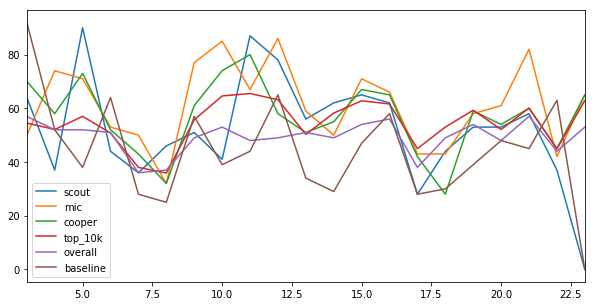

In [139]:
%matplotlib inline
team_points.loc[3:].plot(figsize=(10,5))

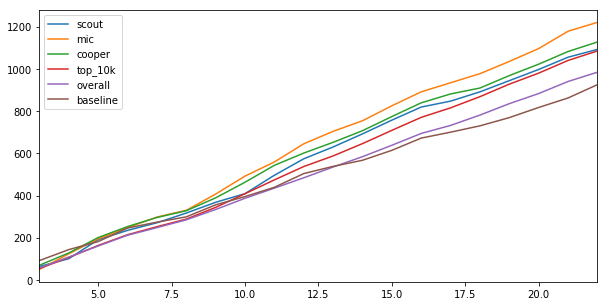

In [140]:
team_points.loc[3:22].cumsum().plot(figsize=(10,5))

In [141]:
team_points.loc[3:22].sum()

scout       1092.0
mic         1220.0
cooper      1127.0
top_10k     1084.6
overall      984.0
baseline     925.0
dtype: float64

In [142]:
df.head()

,id_,web_name,team,element_type,assists,bonus,bps,clean_sheets,goals_scored,minutes,saves,total_points,transfers_in,transfers_out,total_points_1,total_points_2,total_points_3,total_points_4,total_points_5,total_points_6,total_points_7,total_points_8,total_points_9,total_points_10,total_points_11,total_points_12,total_points_13,total_points_14,total_points_15,total_points_16,total_points_17,total_points_18,total_points_19,total_points_20,total_points_21,total_points_22,total_points_23,value_1,value_2,value_3,value_4,value_5,value_6,value_7,value_8,value_9,value_10,value_11,value_12,value_13,value_14,value_15,value_16,value_17,value_18,value_19,value_20,value_21,value_22,value_23,minutes_1,minutes_2,minutes_3,minutes_4,minutes_5,minutes_6,minutes_7,minutes_8,minutes_9,minutes_10,minutes_11,minutes_12,minutes_13,minutes_14,minutes_15,minutes_16,minutes_17,minutes_18,minutes_19,minutes_20,minutes_21,minutes_22,minutes_23
0,215,De Bruyne,11,3,17,20,652,10,7,1890,0,159,4807143,2432472,7.0,11.0,5.0,13.0,1.0,17.0,9.0,0.0,3.0,6.0,2.0,2.0,7.0,10.0,3.0,1.0,19.0,4.0,5.0,14.0,2.0,9.0,2,95.0,1000.0,96.0,1000.0,98.0,1000.0,99.0,100.0,100.0,101.0,102.0,102.0,102.0,1000.0,102.0,103.0,1000.0,103.0,104.0,1000.0,106.0,106.0,107,78.0,90.0,90.0,68.0,33.0,90.0,79.0,0.0,90.0,75.0,90.0,90.0,90.0,90.0,79.0,90.0,90.0,90.0,66.0,90.0,90.0,62.0,90
1,166,Vardy,9,4,6,25,553,7,17,1932,0,150,4065383,1905238,2.0,2.0,8.0,16.0,2.0,2.0,12.0,2.0,8.0,20.0,6.0,12.0,12.0,6.0,5.0,13.0,5.0,9.0,2.0,0.0,0.0,5.0,0,90.0,90.0,89.0,1000.0,89.0,89.0,1000.0,89.0,90.0,1000.0,93.0,1000.0,1000.0,98.0,99.0,100.0,101.0,1000.0,101.0,101.0,101.0,100.0,101,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,0.0,0.0,90.0,90
2,191,Salah,10,3,6,18,423,12,12,1793,0,149,2516173,2881492,12.0,3.0,15.0,6.0,9.0,5.0,3.0,2.0,0.0,7.0,2.0,8.0,0.0,3.0,0.0,13.0,16.0,0.0,3.0,3.0,10.0,6.0,7,125.0,125.0,1000.0,125.0,125.0,125.0,125.0,125.0,124.0,124.0,124.0,123.0,123.0,122.0,122.0,1000.0,1000.0,0.0,122.0,123.0,123.0,123.0,123,90.0,78.0,90.0,90.0,90.0,90.0,90.0,90.0,0.0,84.0,64.0,86.0,0.0,68.0,0.0,90.0,90.0,0.0,69.0,90.0,90.0,90.0,90
3,192,Mané,10,3,8,18,422,9,11,1777,0,147,3608849,2430927,1.0,13.0,3.0,8.0,15.0,2.0,3.0,12.0,2.0,5.0,12.0,7.0,9.0,2.0,15.0,0.0,6.0,0.0,6.0,11.0,8.0,3.0,3,115.0,1000.0,115.0,115.0,1000.0,116.0,116.0,1000.0,118.0,118.0,1000.0,120.0,121.0,122.0,1000.0,123.0,123.0,0.0,122.0,1000.0,123.0,123.0,124,16.0,90.0,76.0,84.0,90.0,70.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,0.0,90.0,0.0,90.0,90.0,77.0,80.0,82
4,182,Alexander-Arnold,10,2,12,14,617,9,2,2099,0,140,2498989,1197839,5.0,1.0,5.0,11.0,2.0,7.0,6.0,3.0,2.0,1.0,7.0,2.0,2.0,10.0,3.0,1.0,6.0,0.0,24.0,8.0,6.0,6.0,10,70.0,70.0,70.0,1000.0,71.0,71.0,72.0,72.0,72.0,72.0,72.0,72.0,72.0,1000.0,72.0,73.0,73.0,0.0,1000.0,1000.0,74.0,75.0,75,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,82.0,50.0,90.0,0.0,90.0,90.0,90.0,90.0,90


In [143]:
histories.head()

,id_,web_name,value,assists,bonus,bps,clean_sheets,goals_scored,minutes,round,saves,selected,total_points,team_a_score,team_h_score,transfers_in,transfers_out,sum_points,sum_minutes,team_a_conceded_rank,team_a_conceded_rank_next,points_per_90,next_week_points
0,215,De Bruyne,95,1,1,37,1,0,78,1,0,868463,7,5,0,0,0,7,78,20,13,8.076923,11
1,215,De Bruyne,95,2,3,44,0,0,90,2,0,995410,11,2,2,81457,79408,18,168,13,14,9.642857,5
2,215,De Bruyne,96,1,0,22,0,0,90,3,0,1566970,5,3,1,510105,49567,23,258,14,15,8.023256,13
3,215,De Bruyne,97,1,2,41,1,1,68,4,0,1914603,13,0,4,373295,80225,36,326,15,20,9.938650,1
4,215,De Bruyne,98,0,0,6,0,0,33,5,0,2386410,1,2,3,438722,38930,37,359,20,20,9.275766,17


In [144]:
def linear_predict(gameweek, data):
    m = ols('next_week_points ~ goals_scored + assists + clean_sheets + saves + value + bps + selected + transfers_in + transfers_out + minutes + points_per_90',  data[data['round'] <= gameweek - 1]).fit()
    next_week = data[data['round'] == gameweek]
    predictions = m.predict(next_week)
    next_week['next_week_predictions'] = predictions   
    return next_week

In [145]:
team_points['linear_points'] = 0

In [146]:
for i in range(2, len(team_points.index) - 1):
    df_linear = linear_predict(i, histories)
    df_copy = df
    df_copy = df_copy.merge(df_linear[['id_', 'next_week_predictions']], how='left', on='id_')
    df_copy = df_copy.fillna(0)
    dream_team = team_select(df_copy.next_week_predictions, df_copy['value_' + str(i)], df_copy)
    next_week_points = dream_team['total_points_' + str(i+1)]
    print(dream_team[['total_points_' + str(i+1), 'web_name', 'minutes_' + str(i + 1)]])
    
    
    
    dream_team_cost = dream_team['value_' + str(i)].sum()
    print('dream team cost: ', dream_team_cost)
    bench_budget = 1000 - dream_team_cost
    print('bench budget: ', bench_budget)
    bench_pool = df_copy
    bench_pool.loc[(bench_pool['id_'].isin(dream_team['id_'])), 'next_week_predictions'] = 0


    dream_team_formation = dream_team['element_type'].value_counts().sort_index()
    bench_formation = [1, 5 - dream_team_formation[2], 5 - dream_team_formation[3], 3 - dream_team_formation[4]]
    bench = bench_select(bench_pool['next_week_predictions'],
                         bench_pool['value_' + str(i)],
                         bench_formation,
                         bench_budget,
                         bench_pool)
    
    print(bench.web_name)
    print('bench cost: ', bench['value_' + str(i)].sum())
    
    
    bench_keeper = bench[bench['element_type'] == 1]
    bench_field = bench[bench['element_type'] != 1].sort_values(['next_week_predictions'], ascending=False)
    print(bench_field[['next_week_predictions', 'total_points_' + str(i + 1), 'web_name', 'team', 'minutes_' + str(i + 1)]])

    
    benched = dream_team[dream_team['minutes_' + str(i + 1)] == 0]
    
    dream_team_played = dream_team[dream_team['minutes_' + str(i + 1)] > 0]
    dream_team_played_formation = dream_team_played['element_type'].value_counts().sort_index()
    dream_team_played_formation_template = pd.Series([0, 0, 0, 0], index=[1, 2, 3, 4])
    for position in dream_team_played_formation.index:
        dream_team_played_formation_template.loc[position] = dream_team_played_formation.loc[position]
    dream_team_played_formation = dream_team_played_formation_template
    print(dream_team_played_formation)  
    
    number_of_benched = benched.shape[0]
    print('num of benched: ', number_of_benched)

    bench_points = 0
    
    if benched[benched['element_type'] == 1].shape[0] > 0:
        bench_points = bench_points + int(bench_keeper['total_points_' + str(i + 1)])
        number_of_benched = number_of_benched - 1
    
    
    
    if (dream_team_played_formation.loc[2] >= 3 and
            dream_team_played_formation.loc[2] <= 5 and
            dream_team_played_formation.loc[3] >= 2 and
            dream_team_played_formation.loc[3] <= 5 and
            dream_team_played_formation.loc[4] >= 1 and
            dream_team_played_formation.loc[4] <= 5):
        bench_points = bench_points + sum(bench_field['total_points_' + str(i + 1)].iloc[:number_of_benched])
        
    else:
        print('ALERT! bench points not added')
        number_of_alerts_linear = number_of_alerts_linear + 1
    
    
    print('bench points: ', bench_points)
    
    
    
    
    
    
    captain = dream_team['next_week_predictions'].idxmax()
    final_points = sum(next_week_points) + dream_team['total_points_' + str(i+1)][captain] + bench_points
    team_points['linear_points'].loc[i] = final_points

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


     total_points_3      web_name  minutes_3
292             2.0        Lloris       90.0
157             1.0          Mina       90.0
318             1.0          Shaw       33.0
323             1.0   El Mohamady        4.0
14              8.0      Sterling       90.0
33              5.0       Martial       90.0
95              0.0       Shelvey        0.0
96              3.0  Douglas Luiz       90.0
8               5.0    Aubameyang       90.0
11             13.0        Agüero       90.0
15              2.0       Firmino       85.0
dream team cost:  827.0
bench budget:  173.0
28        Pope
98       Kelly
397     Hanley
343    Leitner
Name: web_name, dtype: object
bench cost:  170.0
     next_week_predictions  total_points_3 web_name  team  minutes_3
343               2.598849             2.0  Leitner    14       80.0
397               2.135351             1.0   Hanley    14       90.0
98                2.025694             2.0    Kelly     7       90.0
1    1
2    3
3    3
4    3
dt

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


     total_points_4    web_name  minutes_4
29              5.0      Foster       90.0
21              2.0     Pereira       90.0
150             1.0  David Luiz       90.0
351             0.0     Laporte       36.0
14              3.0    Sterling       90.0
25              5.0         Son       78.0
68              8.0       James       90.0
101             5.0        Pépé       90.0
1              16.0       Vardy       90.0
6               5.0     Jiménez       90.0
238             2.0        Gray       81.0
dream team cost:  829.0
bench budget:  171.0
91       Ederson
111       Walker
417    Schelotto
69         Noble
Name: web_name, dtype: object
bench cost:  171.0
     next_week_predictions  total_points_4   web_name  team  minutes_4
69                3.054579             3.0      Noble    19       84.0
111               2.680120             6.0     Walker    11       90.0
417               0.000000             0.0  Schelotto     4        0.0
1    1
2    3
3    4
4    3
dtype: int

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


     total_points_5     web_name  minutes_5
53              2.0         Leno       90.0
132             6.0      Maguire       90.0
158             1.0        Schär       79.0
159             6.0  Wan-Bissaka       90.0
3              15.0         Mané       90.0
68              2.0        James       90.0
174             2.0      Eriksen       90.0
241             2.0        Iwobi       90.0
6               2.0      Jiménez       69.0
8              13.0   Aubameyang       90.0
22              5.0         Kane       84.0
dream team cost:  828.0
bench budget:  172.0
266          Gunn
138           Aké
368        Garcia
139    Sigurdsson
Name: web_name, dtype: object
bench cost:  172.0
     next_week_predictions  total_points_5    web_name  team  minutes_5
139               4.368975             2.0  Sigurdsson     8       70.0
138               2.587094             2.0         Aké     3       90.0
368               0.000000             0.0      Garcia    11        0.0
1    1
2    3
3   

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


     total_points_6          web_name  minutes_6
53              2.0              Leno       90.0
4               7.0  Alexander-Arnold       90.0
97              6.0           Willems       81.0
159             1.0       Wan-Bissaka       90.0
2               5.0             Salah       90.0
14              0.0          Sterling        0.0
37              2.0          Cantwell       89.0
39              2.0             Mount       90.0
122             3.0           Rodrigo       90.0
11              9.0            Agüero       90.0
13              2.0             Pukki       90.0
dream team cost:  827.0
bench budget:  173.0
24     Henderson
118         Rico
390     Tanganga
5       Rashford
Name: web_name, dtype: object
bench cost:  170.0
     next_week_predictions  total_points_6  web_name  team  minutes_6
5                 5.460947             2.0  Rashford    12       60.0
118               2.063100             5.0      Rico     3       90.0
390               0.000000             0

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_7          web_name  minutes_7
53              3.0              Leno       90.0
4               6.0  Alexander-Arnold       90.0
10              8.0          van Dijk       90.0
138             5.0               Aké       90.0
25              5.0               Son       63.0
37              2.0          Cantwell       80.0
39              6.0             Mount       90.0
101             2.0              Pépé       73.0
8               9.0        Aubameyang       90.0
13              2.0             Pukki       90.0
22              8.0              Kane       90.0
dream team cost:  830.0
bench budget:  170.0
81       de Gea
57        Digne
390    Tanganga
184       Kanté
Name: web_name, dtype: object
bench cost:  168.0
     next_week_predictions  total_points_7  web_name  team  minutes_7
57                3.478148             1.0     Digne     8       90.0
184               3.023551             0.0     Kanté     6        0.0
390               0.000000             0.0  

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

     total_points_8    web_name  minutes_8
43              7.0        Ryan       90.0
19              5.0   Lundstram       90.0
57              2.0       Digne       90.0
126             2.0   Cresswell       83.0
0               0.0   De Bruyne        0.0
14              2.0    Sterling       90.0
107             1.0      McGinn       90.0
168             1.0  Yarmolenko       77.0
8               2.0  Aubameyang       90.0
13              1.0       Pukki       83.0
22              2.0        Kane       90.0
dream team cost:  828.0
bench budget:  172.0
91       Ederson
111       Walker
390     Tanganga
134    McTominay
Name: web_name, dtype: object
bench cost:  171.0
     next_week_predictions  total_points_8   web_name  team  minutes_8
111               3.410336             1.0     Walker    11       45.0
134               3.081507             1.0  McTominay    12       90.0
390               0.000000             0.0   Tanganga    17        0.0
1    1
2    3
3    3
4    3
dtype: int

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


     total_points_9          web_name  minutes_9
35              3.0        Schmeichel       90.0
4               2.0  Alexander-Arnold       90.0
10              2.0          van Dijk       90.0
137             1.0       van Aanholt       90.0
2               0.0             Salah        0.0
14              5.0          Sterling       90.0
39              3.0             Mount       63.0
184             0.0             Kanté        0.0
7               2.0           Abraham       90.0
13              1.0             Pukki       90.0
49              2.0            Haller       90.0
dream team cost:  828.0
bench budget:  172.0
366    McGovern
98        Kelly
118        Rico
37     Cantwell
Name: web_name, dtype: object
bench cost:  172.0
     next_week_predictions  total_points_9  web_name  team  minutes_9
37                2.860853             3.0  Cantwell    14       80.0
98                2.610727             0.0     Kelly     7        0.0
118               2.482341             8.0  

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


     total_points_10          web_name  minutes_10
333              2.0           Roberto        90.0
4                1.0  Alexander-Arnold        90.0
10               2.0          van Dijk        90.0
155             -1.0           Webster        90.0
0                6.0         De Bruyne        75.0
3                5.0              Mané        90.0
32               2.0              Alli        90.0
61              11.0         Tielemans        90.0
1               20.0             Vardy        90.0
7                5.0           Abraham        69.0
13               2.0             Pukki        90.0
dream team cost:  829.0
bench budget:  171.0
401    Hennessey
12     Robertson
390     Tanganga
75      Doucouré
Name: web_name, dtype: object
bench cost:  170.0
     next_week_predictions  total_points_10   web_name  team  minutes_10
12                3.561782              2.0  Robertson    10        90.0
75                3.266919              2.0   Doucouré    18        90.0
390    

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


     total_points_11    web_name  minutes_11
128              2.0   Gazzaniga        90.0
19              21.0   Lundstram        90.0
150              2.0  David Luiz        90.0
156              2.0    Sokratis        90.0
2                2.0       Salah        64.0
3               12.0        Mané        90.0
25               2.0         Son        78.0
60               2.0   Henderson        90.0
13               2.0       Pukki        90.0
22               0.0        Kane         0.0
41               2.0      Maupay        90.0
dream team cost:  830.0
bench budget:  170.0
266        Gunn
10     van Dijk
390    Tanganga
78       McNeil
Name: web_name, dtype: object
bench cost:  170.0
     next_week_predictions  total_points_11  web_name  team  minutes_11
10                3.484156              1.0  van Dijk    10        90.0
78                3.418294              1.0    McNeil     5        58.0
390               0.000000              0.0  Tanganga    17         0.0
1    1
2    3


C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


    total_points_12          web_name  minutes_12
29              9.0            Foster        90.0
4               2.0  Alexander-Arnold        90.0
10              2.0          van Dijk        90.0
12              5.0         Robertson        90.0
57              2.0             Digne        90.0
0               2.0         De Bruyne        90.0
39              3.0             Mount        86.0
83              8.0           Pulisic        79.0
1              12.0             Vardy        90.0
8               2.0        Aubameyang        90.0
13              2.0             Pukki        90.0
dream team cost:  829.0
bench budget:  171.0
81          de Gea
390       Tanganga
58     Ward-Prowse
107         McGinn
Name: web_name, dtype: object
bench cost:  171.0
     next_week_predictions  total_points_12     web_name  team  minutes_12
58                3.292271              2.0  Ward-Prowse    16        90.0
107               3.263510              2.0       McGinn     2        90.0
390  

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


     total_points_13   web_name  minutes_13
333              2.0    Roberto        90.0
10               2.0   van Dijk        90.0
19               3.0  Lundstram        90.0
63               0.0       Dunk         0.0
2                0.0      Salah         0.0
3                9.0       Mané        90.0
17               3.0   Maddison        90.0
83               2.0    Pulisic        90.0
5               11.0   Rashford        90.0
6                7.0    Jiménez        90.0
7                2.0    Abraham        72.0
dream team cost:  829.0
bench budget:  171.0
43            Ryan
26         Baldock
390       Tanganga
18     Richarlison
Name: web_name, dtype: object
bench cost:  171.0
     next_week_predictions  total_points_13     web_name  team  minutes_13
18                4.200929              2.0  Richarlison     8        90.0
26                2.912877              1.0      Baldock    15        90.0
390               0.000000              0.0     Tanganga    17         0.0
1 

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


    total_points_14          web_name  minutes_14
43              2.0              Ryan        90.0
4              10.0  Alexander-Arnold        90.0
19              2.0         Lundstram        90.0
47              2.0           Söyüncü        90.0
0              10.0         De Bruyne        90.0
3               2.0              Mané        90.0
17              2.0          Maddison        90.0
51              2.0          Moutinho        90.0
6               5.0           Jiménez        90.0
7               0.0           Abraham         0.0
22              2.0              Kane        90.0
dream team cost:  830.0
bench budget:  170.0
189      McCarthy
118          Rico
276      Williams
108    Dendoncker
Name: web_name, dtype: object
bench cost:  170.0
     next_week_predictions  total_points_14    web_name  team  minutes_14
276               2.697148              0.0    Williams    12        78.0
118               2.574697              0.0        Rico     3        90.0
108         

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


    total_points_15   web_name  minutes_15
43              3.0       Ryan        90.0
19              1.0  Lundstram        90.0
21              7.0    Pereira        90.0
47              5.0    Söyüncü        90.0
3              15.0       Mané        90.0
14              3.0   Sterling        71.0
39              6.0      Mount        90.0
83              2.0    Pulisic        85.0
1               5.0      Vardy        90.0
6               2.0    Jiménez        83.0
9               9.0       Ings        76.0
dream team cost:  830.0
bench budget:  170.0
189    McCarthy
98        Kelly
403      Kilman
37     Cantwell
Name: web_name, dtype: object
bench cost:  170.0
     next_week_predictions  total_points_15  web_name  team  minutes_15
37                3.048848              2.0  Cantwell    14        82.0
98                2.639848              6.0     Kelly     7        90.0
403               2.211070              0.0    Kilman    20         0.0
1    1
2    3
3    4
4    3
dtype: int

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


    total_points_16          web_name  minutes_16
43              2.0              Ryan        90.0
4               1.0  Alexander-Arnold        50.0
10              6.0          van Dijk        90.0
19              2.0         Lundstram        90.0
0               1.0         De Bruyne        90.0
25             12.0               Son        90.0
32              9.0              Alli        84.0
39              2.0             Mount        90.0
1              13.0             Vardy        90.0
7               2.0           Abraham        90.0
13              2.0             Pukki        90.0
dream team cost:  829.0
bench budget:  171.0
320      Martin
98        Kelly
155     Webster
37     Cantwell
Name: web_name, dtype: object
bench cost:  171.0
     next_week_predictions  total_points_16  web_name  team  minutes_16
155               2.755714              1.0   Webster     4        90.0
37                2.724929              1.0  Cantwell    14        18.0
98                2.644756

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


    total_points_17   web_name  minutes_17
91              6.0    Ederson        90.0
10              7.0   van Dijk        90.0
19             11.0  Lundstram        90.0
47              3.0    Söyüncü        90.0
0              19.0  De Bruyne        90.0
17              2.0   Maddison        90.0
32              2.0       Alli        90.0
39              2.0      Mount        90.0
1               5.0      Vardy        90.0
5               2.0   Rashford        90.0
7               2.0    Abraham        90.0
dream team cost:  825.0
bench budget:  175.0
189    McCarthy
98        Kelly
105     Ogbonna
194      Tettey
Name: web_name, dtype: object
bench cost:  175.0
     next_week_predictions  total_points_17 web_name  team  minutes_17
98                2.959189              2.0    Kelly     7        90.0
194               2.776125              1.0   Tettey    14        90.0
105               2.682276              6.0  Ogbonna    19        90.0
1    1
2    3
3    4
4    3
dtype: int64
n

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


    total_points_18  web_name  minutes_18
45              2.0    Guaita        90.0
10              0.0  van Dijk         0.0
47              0.0   Söyüncü        90.0
98              2.0     Kelly        90.0
3               0.0      Mané         0.0
17              2.0  Maddison        90.0
25             -1.0       Son        61.0
37             10.0  Cantwell        86.0
1               9.0     Vardy        90.0
5               2.0  Rashford        90.0
7               2.0   Abraham        79.0
dream team cost:  828.0
bench budget:  172.0
71             Pickford
4      Alexander-Arnold
118                Rico
389                Duda
Name: web_name, dtype: object
bench cost:  170.0
     next_week_predictions  total_points_18          web_name  team  \
4                 4.111404              0.0  Alexander-Arnold    10   
118               2.683669              1.0              Rico     3   
389               0.000000              0.0              Duda    14   

     minutes_18  
4  

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


     total_points_19    web_name  minutes_19
35               0.0  Schmeichel        90.0
19               2.0   Lundstram        90.0
98               2.0       Kelly        90.0
118              0.0        Rico         0.0
0                5.0   De Bruyne        66.0
14              10.0    Sterling        90.0
17               1.0    Maddison        75.0
20               6.0    Grealish        90.0
5                6.0    Rashford        62.0
6               11.0     Jiménez        90.0
22               8.0        Kane        90.0
dream team cost:  830.0
bench budget:  170.0
29         Foster
57          Digne
136    Fredericks
39          Mount
Name: web_name, dtype: object
bench cost:  170.0
     next_week_predictions  total_points_19    web_name  team  minutes_19
39                3.817528              1.0       Mount     6        45.0
57                3.226817              6.0       Digne     8        90.0
136               0.000000              0.0  Fredericks    19         0.

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


    total_points_20   web_name  minutes_20
28              1.0       Pope        90.0
10              6.0   van Dijk        90.0
12              6.0  Robertson        90.0
19              0.0  Lundstram         0.0
0              14.0  De Bruyne        90.0
20              1.0   Grealish        90.0
32              2.0       Alli        90.0
37              1.0   Cantwell         4.0
1               0.0      Vardy         0.0
7               7.0    Abraham        90.0
22              8.0       Kane        90.0
dream team cost:  827.0
bench budget:  173.0
128     Gazzaniga
98          Kelly
424       Simpson
108    Dendoncker
Name: web_name, dtype: object
bench cost:  173.0
     next_week_predictions  total_points_20    web_name  team  minutes_20
98                3.177070              2.0       Kelly     7        90.0
108               2.571055              1.0  Dendoncker    20        57.0
424               2.333272              0.0     Simpson     3         0.0
1    1
2    2
3    4
4

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


     total_points_21  web_name  minutes_21
34               3.0  Dubravka        90.0
10               7.0  van Dijk        90.0
98               2.0     Kelly        82.0
132              1.0   Maguire        90.0
2               10.0     Salah        90.0
14               1.0  Sterling         1.0
20              13.0  Grealish        90.0
33               2.0   Martial        90.0
5                2.0  Rashford        90.0
7                5.0   Abraham        90.0
9                9.0      Ings        75.0
dream team cost:  828.0
bench budget:  172.0
35     Schmeichel
12      Robertson
63           Dunk
389          Duda
Name: web_name, dtype: object
bench cost:  171.0
     next_week_predictions  total_points_21   web_name  team  minutes_21
12                3.761282             12.0  Robertson    10        87.0
63                2.858989              4.0       Dunk     4        90.0
389               0.000000              0.0       Duda    14         0.0
1    1
2    3
3    4
4    

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


    total_points_22          web_name  minutes_22
35              4.0        Schmeichel        90.0
4               6.0  Alexander-Arnold        90.0
10              6.0          van Dijk        90.0
19              6.0         Lundstram        69.0
0               9.0         De Bruyne        62.0
3               3.0              Mané        80.0
17              2.0          Maddison        90.0
27              2.0            Traoré        90.0
33              8.0           Martial        79.0
7               6.0           Abraham        90.0
9               5.0              Ings        90.0
dream team cost:  829.0
bench budget:  171.0
428    Randolph
47      Söyüncü
98        Kelly
6       Jiménez
Name: web_name, dtype: object
bench cost:  170.0
    next_week_predictions  total_points_22 web_name  team  minutes_22
6                4.015855              2.0  Jiménez    20        90.0
47               3.255952              1.0  Söyüncü     9        90.0
98               2.999457       

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


    total_points_23          web_name  minutes_23
35                2        Schmeichel          90
4                10  Alexander-Arnold          90
10               15          van Dijk          90
19                2         Lundstram          66
3                 3              Mané          82
17                2          Maddison          90
18                0       Richarlison           0
27               10            Traoré          90
1                 0             Vardy          90
7                 2           Abraham          79
9                 2              Ings          90
dream team cost:  826.0
bench budget:  174.0
128     Gazzaniga
98          Kelly
390      Tanganga
108    Dendoncker
Name: web_name, dtype: object
bench cost:  174.0
     next_week_predictions  total_points_23    web_name  team  minutes_23
98                3.129363                1       Kelly     7          90
108               2.858468                2  Dendoncker    20          90
390         

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


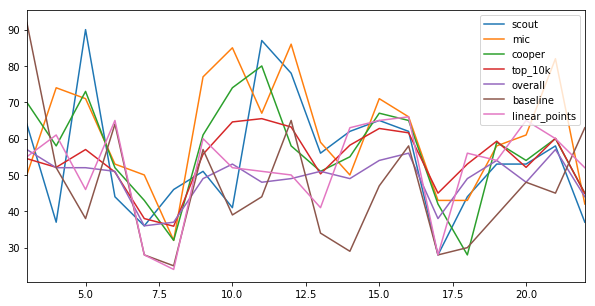

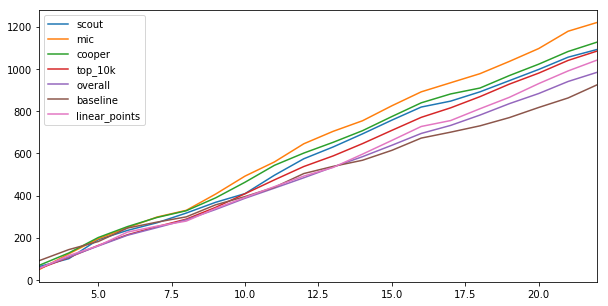

In [147]:
%matplotlib inline
team_points.loc[3:22].plot(figsize=(10,5))
team_points.loc[3:22].cumsum().plot(figsize=(10,5))

In [153]:
team_points.loc[3:22].sum()

scout            1092.0
mic              1220.0
cooper           1127.0
top_10k          1084.6
overall           984.0
baseline          925.0
linear_points    1042.0
dtype: float64

In [154]:
from sklearn.ensemble import RandomForestRegressor

In [155]:
team_points.shape

(24, 7)

In [156]:
histories.head()

,id_,web_name,value,assists,bonus,bps,clean_sheets,goals_scored,minutes,round,saves,selected,total_points,team_a_score,team_h_score,transfers_in,transfers_out,sum_points,sum_minutes,team_a_conceded_rank,team_a_conceded_rank_next,points_per_90,next_week_points
0,215,De Bruyne,95,1,1,37,1,0,78,1,0,868463,7,5,0,0,0,7,78,20,13,8.076923,11
1,215,De Bruyne,95,2,3,44,0,0,90,2,0,995410,11,2,2,81457,79408,18,168,13,14,9.642857,5
2,215,De Bruyne,96,1,0,22,0,0,90,3,0,1566970,5,3,1,510105,49567,23,258,14,15,8.023256,13
3,215,De Bruyne,97,1,2,41,1,1,68,4,0,1914603,13,0,4,373295,80225,36,326,15,20,9.938650,1
4,215,De Bruyne,98,0,0,6,0,0,33,5,0,2386410,1,2,3,438722,38930,37,359,20,20,9.275766,17


In [157]:
df_forest = histories[['id_', 'assists', 'bonus', 'bps', 'clean_sheets', 'goals_scored', 
                 'minutes', 'round', 'saves', 'selected', 
                 'total_points',
                 'transfers_in', 
                 'team_a_conceded_rank', 'team_a_conceded_rank_next',
                 'transfers_out',
                 'points_per_90', 'next_week_points']].sort_values('round')

In [158]:
df_forest.head()

,id_,assists,bonus,bps,clean_sheets,goals_scored,minutes,round,saves,selected,total_points,transfers_in,team_a_conceded_rank,team_a_conceded_rank_next,transfers_out,points_per_90,next_week_points
0,215,1,1,37,1,0,78,1,0,868463,7,0,20,13,0,8.076923,11
2784,184,0,0,10,0,0,90,1,0,101038,2,0,16,17,0,2.000000,0
2808,68,0,0,6,0,0,90,1,0,1189451,2,0,10,17,0,2.000000,6
2832,65,0,0,13,0,0,90,1,0,281145,2,0,10,17,0,2.000000,0
9539,132,0,0,0,0,0,0,1,0,63901,0,0,1,2,0,0.000000,0


In [239]:
def forest_predict(gameweek):
    df_clean = df_forest.drop('id_', axis=1)
    df_clean = df_clean[df_clean['round'] <= gameweek - 1]
    X_train = df_clean.drop('next_week_points', axis=1)
    y_train = df_clean.next_week_points
    rfr = RandomForestRegressor(n_estimators=275, max_depth=4, random_state=42)
    rfr.fit(X_train, y_train)
    next_week = df_forest[df_forest['round'] == gameweek]
    X_test = next_week.drop(['id_', 'next_week_points'], axis=1)
    y_pred = rfr.predict(X_test)
    next_week['forest_predictions'] = y_pred
    return next_week
    
    
    

In [240]:
team_points['forest_points'] = 0

In [241]:
for i in range(2, len(team_points.index) - 1):
    df_forest_predictions = forest_predict(i)
    df_copy = df
    df_copy = df_copy.merge(df_forest_predictions[['id_', 'forest_predictions']], how='left', on='id_')
    df_copy = df_copy.fillna(0)
    dream_team = team_select(df_copy.forest_predictions, df_copy['value_' + str(i)], df_copy)
    next_week_points = dream_team['total_points_' + str(i+1)]
    print(dream_team[['total_points_' + str(i+1), 'web_name', 'minutes_' + str(i + 1)]])
    
    dream_team_cost = dream_team['value_' + str(i)].sum()
    print('dream team cost: ', dream_team_cost)
    bench_budget = 1000 - dream_team_cost
    print('bench budget: ', bench_budget)
    bench_pool = df_copy
    bench_pool.loc[(bench_pool['id_'].isin(dream_team['id_'])), 'forest_predictions'] = 0


    dream_team_formation = dream_team['element_type'].value_counts().sort_index()
    bench_formation = [1, 5 - dream_team_formation[2], 5 - dream_team_formation[3], 3 - dream_team_formation[4]]
    bench = bench_select(bench_pool['forest_predictions'],
                         bench_pool['value_' + str(i)],
                         bench_formation,
                         bench_budget,
                         bench_pool)
    
    print(bench.web_name)
    print('bench cost: ', bench['value_' + str(i)].sum())
    
    
    bench_keeper = bench[bench['element_type'] == 1]
    bench_field = bench[bench['element_type'] != 1].sort_values(['forest_predictions'], ascending=False)
    print(bench_field[['forest_predictions', 'total_points_' + str(i + 1), 'web_name', 'team', 'minutes_' + str(i + 1)]])

    
    benched = dream_team[dream_team['minutes_' + str(i + 1)] == 0]
    
    dream_team_played = dream_team[dream_team['minutes_' + str(i + 1)] > 0]
    dream_team_played_formation = dream_team_played['element_type'].value_counts().sort_index()
    dream_team_played_formation_template = pd.Series([0, 0, 0, 0], index=[1, 2, 3, 4])
    for position in dream_team_played_formation.index:
        dream_team_played_formation_template.loc[position] = dream_team_played_formation.loc[position]
    dream_team_played_formation = dream_team_played_formation_template
    print(dream_team_played_formation)
    
    number_of_benched = benched.shape[0]
    print('num of benched: ', number_of_benched)

    bench_points = 0
    
        
    if benched[benched['element_type'] == 1].shape[0] > 0:
        bench_points = bench_points + int(bench_keeper['total_points_' + str(i + 1)])
        number_of_benched = number_of_benched - 1
    
    
    
    if (dream_team_played_formation.loc[2] >= 3 and
                    dream_team_played_formation.loc[2] <= 5 and
                    dream_team_played_formation.loc[3] >= 2 and
                    dream_team_played_formation.loc[3] <= 5 and
                    dream_team_played_formation.loc[4] >= 1 and
                    dream_team_played_formation.loc[4] <= 5):
        bench_points = bench_points + sum(bench_field['total_points_' + str(i + 1)].iloc[:number_of_benched])
        
    else:
        print('ALERT! bench points not added')
        number_of_alerts_forest = number_of_alerts_forest + 1

    
    print('bench points: ', bench_points)

    
    
    
    
    captain = dream_team['forest_predictions'].idxmax()
    final_points = sum(next_week_points) + dream_team['total_points_' + str(i+1)][captain] + bench_points
    team_points['forest_points'].loc[i] = final_points

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_3     web_name  minutes_3
91              3.0      Ederson       90.0
63              1.0         Dunk       90.0
98              2.0        Kelly       90.0
159             0.0  Wan-Bissaka       90.0
33              5.0      Martial       90.0
93              2.0     Trossard       90.0
99              2.0  Lucas Moura       90.0
115             2.0        Neves       90.0
5               0.0     Rashford       90.0
8               5.0   Aubameyang       90.0
112             1.0    Lacazette        9.0
dream team cost:  758.0
bench budget:  242.0
81          de Gea
10        van Dijk
323    El Mohamady
123           Groß
Name: web_name, dtype: object
bench cost:  231.0
     forest_predictions  total_points_3     web_name  team  minutes_3
123            3.768940             1.0         Groß     4       12.0
323            3.270725             1.0  El Mohamady     2        4.0
10             3.252227             2.0     van Dijk    10       90.0
1    1
2    3
3    4
4

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_4    web_name  minutes_4
50              2.0    Patrício       90.0
10              7.0    van Dijk       90.0
12              6.0   Robertson       90.0
180             0.0      Alonso        0.0
14              3.0    Sterling       90.0
39              2.0       Mount       90.0
139             5.0  Sigurdsson       90.0
372             0.0       Pedro        0.0
1              16.0       Vardy       90.0
6               5.0     Jiménez       90.0
13              2.0       Pukki       90.0
dream team cost:  812.0
bench budget:  188.0
53          Leno
19     Lundstram
138          Aké
37      Cantwell
Name: web_name, dtype: object
bench cost:  187.0
     forest_predictions  total_points_4   web_name  team  minutes_4
37             3.725183             2.0   Cantwell    14       77.0
138            3.178253             1.0        Aké     3       90.0
19             2.873546             1.0  Lundstram    15       90.0
1    1
2    2
3    3
4    3
dtype: int64
num of be

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_5        web_name  minutes_5
91              1.0         Ederson       90.0
10              2.0        van Dijk       90.0
12              5.0       Robertson       90.0
111             1.0          Walker       90.0
159             6.0     Wan-Bissaka       90.0
3              15.0            Mané       90.0
73              4.0  Bernardo Silva       72.0
139             2.0      Sigurdsson       70.0
6               2.0         Jiménez       69.0
8              13.0      Aubameyang       90.0
44              1.0            Ayew       70.0
dream team cost:  817.0
bench budget:  183.0
43           Ryan
98          Kelly
72       Jorginho
108    Dendoncker
Name: web_name, dtype: object
bench cost:  182.0
     forest_predictions  total_points_5    web_name  team  minutes_5
98             3.913871             0.0       Kelly     7        0.0
108            3.701519             1.0  Dendoncker    20       45.0
72             3.377393             5.0    Jorginho     6      

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_6     web_name  minutes_6
81              2.0       de Gea       90.0
10              2.0     van Dijk       90.0
12              8.0    Robertson       90.0
159             1.0  Wan-Bissaka       90.0
2               5.0        Salah       90.0
14              0.0     Sterling        0.0
37              2.0     Cantwell       89.0
39              2.0        Mount       90.0
5               2.0     Rashford       60.0
13              2.0        Pukki       90.0
117             2.0         King       90.0
dream team cost:  823.0
bench budget:  177.0
428          Randolph
19          Lundstram
132           Maguire
73     Bernardo Silva
Name: web_name, dtype: object
bench cost:  175.0
     forest_predictions  total_points_6        web_name  team  minutes_6
73             5.043303            19.0  Bernardo Silva    11       90.0
132            4.729301             1.0         Maguire    12       90.0
19             2.927707            12.0       Lundstram    15       90.

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_7          web_name  minutes_7
91              4.0           Ederson       90.0
4               6.0  Alexander-Arnold       90.0
10              8.0          van Dijk       90.0
111             2.0            Walker       90.0
2               3.0             Salah       90.0
37              2.0          Cantwell       80.0
39              6.0             Mount       90.0
42              1.0       David Silva        4.0
7               2.0           Abraham       83.0
13              2.0             Pukki       90.0
22              8.0              Kane       90.0
dream team cost:  825.0
bench budget:  175.0
48       Ramsdale
118          Rico
205         Saïss
108    Dendoncker
Name: web_name, dtype: object
bench cost:  175.0
     forest_predictions  total_points_7    web_name  team  minutes_7
108            3.477078             3.0  Dendoncker    20       90.0
205            2.821681             6.0       Saïss    20       90.0
118            2.713510             0.0

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_8    web_name  minutes_8
24              6.0   Henderson       90.0
10              2.0    van Dijk       90.0
19              5.0   Lundstram       90.0
247             6.0      Engels       74.0
2               2.0       Salah       90.0
14              2.0    Sterling       90.0
39              7.0       Mount       79.0
107             1.0      McGinn       90.0
7               8.0     Abraham       83.0
8               2.0  Aubameyang       90.0
13              1.0       Pukki       83.0
dream team cost:  825.0
bench budget:  175.0
114     Heaton
26     Baldock
98       Kelly
268    Nakamba
Name: web_name, dtype: object
bench cost:  175.0
     forest_predictions  total_points_8 web_name  team  minutes_8
268            4.020336             2.0  Nakamba     2       90.0
26             3.887965             6.0  Baldock    15       90.0
98             3.405309             7.0    Kelly     7       90.0
1    1
2    3
3    4
4    3
dtype: int64
num of benched:  0
bench 

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_9    web_name  minutes_9
48              6.0    Ramsdale       90.0
118             8.0        Rico       90.0
176             2.0  Vertonghen       90.0
192             9.0  Steve Cook       90.0
2               0.0       Salah        0.0
25              1.0         Son       45.0
37              3.0    Cantwell       80.0
172             1.0     Sissoko       90.0
7               2.0     Abraham       90.0
11              0.0      Agüero        0.0
13              1.0       Pukki       90.0
dream team cost:  782.0
bench budget:  218.0
128       Gazzaniga
152    Alderweireld
306          Stacey
204         Billing
Name: web_name, dtype: object
bench cost:  193.0
     forest_predictions  total_points_9      web_name  team  minutes_9
204            4.468723             3.0       Billing     3       90.0
306            4.371000             0.0        Stacey     3        0.0
152            4.346631             2.0  Alderweireld    17       90.0
1    1
2    3
3    3
4    

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_10        web_name  minutes_10
81               2.0          de Gea        90.0
21               6.0         Pereira        90.0
38               6.0           Evans        90.0
47               6.0         Söyüncü        90.0
57              -1.0           Digne        90.0
159              1.0     Wan-Bissaka        90.0
0                6.0       De Bruyne        75.0
68               6.0           James        79.0
73               3.0  Bernardo Silva        90.0
13               2.0           Pukki        90.0
22               7.0            Kane        90.0
dream team cost:  748.0
bench budget:  252.0
35     Schmeichel
17       Maddison
102         Ndidi
7         Abraham
Name: web_name, dtype: object
bench cost:  250.0
     forest_predictions  total_points_10  web_name  team  minutes_10
17             3.996315              8.0  Maddison     9        90.0
102            3.961172              3.0     Ndidi     9        90.0
7              3.816399              5.

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


    total_points_11          web_name  minutes_11
43              6.0              Ryan        90.0
4               7.0  Alexander-Arnold        90.0
10              1.0          van Dijk        90.0
63              7.0              Dunk        90.0
0               2.0         De Bruyne        90.0
2               2.0             Salah        64.0
42              1.0       David Silva        45.0
73              2.0    Bernardo Silva        83.0
7              12.0           Abraham        87.0
13              2.0             Pukki        90.0
41              2.0            Maupay        90.0
dream team cost:  818.0
bench budget:  182.0
91      Ederson
230       Mendy
390    Tanganga
185    Gündogan
Name: web_name, dtype: object
bench cost:  172.0
     forest_predictions  total_points_11  web_name  team  minutes_11
230            5.290670              0.0     Mendy    11         0.0
185            5.269102              1.0  Gündogan    11        90.0
390            0.000000            

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_12     web_name  minutes_12
50               3.0     Patrício        90.0
57               2.0        Digne        90.0
64               6.0     Chilwell        90.0
157              2.0         Mina        90.0
0                2.0    De Bruyne        90.0
17               9.0     Maddison        90.0
18              10.0  Richarlison        88.0
108              2.0   Dendoncker        90.0
1               12.0        Vardy        90.0
11               2.0       Agüero        70.0
13               2.0        Pukki        90.0
dream team cost:  802.0
bench budget:  198.0
71        Pickford
118           Rico
232        Janmaat
364    André Gomes
Name: web_name, dtype: object
bench cost:  194.0
     forest_predictions  total_points_12     web_name  team  minutes_12
364            3.665047              0.0  André Gomes     8         0.0
232            3.593876              7.0      Janmaat    18        90.0
118            3.578862              1.0         Rico     3   

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_13     web_name  minutes_13
71               2.0     Pickford        90.0
19               3.0    Lundstram        90.0
57               1.0        Digne        90.0
150              1.0   David Luiz        90.0
3                9.0         Mané        90.0
18               2.0  Richarlison        90.0
39               1.0        Mount        16.0
210              1.0    Guendouzi        90.0
8                5.0   Aubameyang        90.0
13               5.0        Pukki        90.0
22               6.0         Kane        90.0
dream team cost:  821.0
bench budget:  179.0
28             Pope
170         Holgate
201        Chambers
352    Schneiderlin
Name: web_name, dtype: object
bench cost:  179.0
     forest_predictions  total_points_13      web_name  team  minutes_13
201            4.022710              1.0      Chambers     1        45.0
352            3.640811              0.0  Schneiderlin     8        55.0
170            3.421062              0.0       Holgate 

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


    total_points_14    web_name  minutes_14
29              2.0      Foster        90.0
12              2.0   Robertson        90.0
21              7.0     Pereira        90.0
47              2.0     Söyüncü        90.0
0              10.0   De Bruyne        90.0
3               2.0        Mané        90.0
37              8.0    Cantwell        82.0
83              2.0     Pulisic        90.0
7               0.0     Abraham         0.0
8              13.0  Aubameyang        90.0
62              2.0    Deulofeu        66.0
dream team cost:  825.0
bench budget:  175.0
28           Pope
94       Cathcart
276      Williams
108    Dendoncker
Name: web_name, dtype: object
bench cost:  175.0
     forest_predictions  total_points_14    web_name  team  minutes_14
94             3.283930              1.0    Cathcart    18        90.0
108            3.100579              1.0  Dendoncker    20        90.0
276            2.830073              0.0    Williams    12        78.0
1    1
2    3
3    4
4

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


    total_points_15   web_name  minutes_15
43              3.0       Ryan        90.0
19              1.0  Lundstram        90.0
21              7.0    Pereira        90.0
98              6.0      Kelly        90.0
2               0.0      Salah         0.0
3              15.0       Mané        90.0
17             10.0   Maddison        90.0
37              2.0   Cantwell        82.0
1               5.0      Vardy        90.0
6               2.0    Jiménez        83.0
13              8.0      Pukki        90.0
dream team cost:  808.0
bench budget:  192.0
92          Krul
47       Söyüncü
63          Dunk
210    Guendouzi
Name: web_name, dtype: object
bench cost:  187.0
     forest_predictions  total_points_15   web_name  team  minutes_15
47             3.932902              5.0    Söyüncü     9        90.0
63             3.805481              2.0       Dunk     4        90.0
210            3.610771              0.0  Guendouzi     1         0.0
1    1
2    3
3    3
4    3
dtype: int64
n

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


    total_points_16          web_name  minutes_16
35              2.0        Schmeichel        90.0
4               1.0  Alexander-Arnold        50.0
19              2.0         Lundstram        90.0
21              1.0           Pereira        90.0
98              8.0             Kelly        90.0
25             12.0               Son        90.0
39              2.0             Mount        90.0
83              2.0           Pulisic        90.0
1              13.0             Vardy        90.0
7               2.0           Abraham        90.0
8              12.0        Aubameyang        90.0
dream team cost:  806.0
bench budget:  194.0
50     Patrício
47      Söyüncü
37     Cantwell
151      Hayden
Name: web_name, dtype: object
bench cost:  192.0
     forest_predictions  total_points_16  web_name  team  minutes_16
47             3.926987              2.0   Söyüncü     9        90.0
151            3.520582              2.0    Hayden    13        90.0
37             3.423748            

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


    total_points_17   web_name  minutes_17
24              6.0  Henderson        90.0
10              7.0   van Dijk        90.0
19             11.0  Lundstram        90.0
47              3.0    Söyüncü        90.0
98              2.0      Kelly        90.0
0              19.0  De Bruyne        90.0
3               6.0       Mané        90.0
17              2.0   Maddison        90.0
1               5.0      Vardy        90.0
5               2.0   Rashford        90.0
7               2.0    Abraham        90.0
dream team cost:  825.0
bench budget:  175.0
320        Martin
97        Willems
108    Dendoncker
151        Hayden
Name: web_name, dtype: object
bench cost:  174.0
     forest_predictions  total_points_17    web_name  team  minutes_17
97             3.307491              2.0     Willems    13        70.0
108            3.255372              1.0  Dendoncker    20        90.0
151            2.878994              2.0      Hayden    13        90.0
1    1
2    4
3    3
4    3
dtype:

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_18     web_name  minutes_18
50               4.0     Patrício        90.0
98               2.0        Kelly        90.0
118              1.0         Rico        90.0
159              1.0  Wan-Bissaka        90.0
3                0.0         Mané         0.0
25              -1.0          Son        61.0
39               3.0        Mount        90.0
68               1.0        James        57.0
5                2.0     Rashford        90.0
6                7.0      Jiménez        90.0
7                2.0      Abraham        79.0
dream team cost:  786.0
bench budget:  214.0
81       de Gea
47      Söyüncü
132     Maguire
51     Moutinho
Name: web_name, dtype: object
bench cost:  213.0
     forest_predictions  total_points_18  web_name  team  minutes_18
132            3.740003              1.0   Maguire    12        90.0
51             3.653977              4.0  Moutinho    20        90.0
47             3.489738              0.0   Söyüncü     9        90.0
1    1
2    3


C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_19   web_name  minutes_19
114             10.0     Heaton        90.0
19               2.0  Lundstram        90.0
26               6.0    Baldock        90.0
98               2.0      Kelly        90.0
0                5.0  De Bruyne        66.0
14              10.0   Sterling        90.0
20               6.0   Grealish        90.0
39               1.0      Mount        45.0
5                6.0   Rashford        62.0
7                2.0    Abraham        90.0
13               1.0      Pukki        90.0
dream team cost:  774.0
bench budget:  226.0
43         Ryan
47      Söyüncü
59    O'Connell
17     Maddison
Name: web_name, dtype: object
bench cost:  223.0
    forest_predictions  total_points_19   web_name  team  minutes_19
17            3.994211              1.0   Maddison     9        75.0
47            3.484176              0.0    Söyüncü     9        90.0
59            3.405806              2.0  O'Connell    15        90.0
1    1
2    3
3    4
4    3
dtype: int

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


    total_points_20   web_name  minutes_20
45              3.0     Guaita        90.0
10              6.0   van Dijk        90.0
19              0.0  Lundstram         0.0
98              2.0      Kelly        90.0
3              11.0       Mané        90.0
17              1.0   Maddison        26.0
32              2.0       Alli        90.0
37              1.0   Cantwell         4.0
1               0.0      Vardy         0.0
5               9.0   Rashford        90.0
7               7.0    Abraham        90.0
dream team cost:  819.0
bench budget:  181.0
128       Gazzaniga
84           Aurier
424         Simpson
96     Douglas Luiz
Name: web_name, dtype: object
bench cost:  180.0
     forest_predictions  total_points_20      web_name  team  minutes_20
84             3.788330             -1.0        Aurier    17        90.0
424            3.155594              0.0       Simpson     3         0.0
96             3.051653              2.0  Douglas Luiz     2        90.0
1    1
2    2
3   

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


    total_points_21   web_name  minutes_21
45              3.0     Guaita        90.0
10              7.0   van Dijk        90.0
12             12.0  Robertson        87.0
19              1.0  Lundstram        90.0
98              2.0      Kelly        82.0
17             11.0   Maddison        76.0
32              2.0       Alli        90.0
39              3.0      Mount        72.0
1               0.0      Vardy         0.0
5               2.0   Rashford        90.0
22              2.0       Kane        74.0
dream team cost:  813.0
bench budget:  187.0
114          Heaton
127         Targett
27           Traoré
96     Douglas Luiz
Name: web_name, dtype: object
bench cost:  187.0
     forest_predictions  total_points_21      web_name  team  minutes_21
96             3.354462              7.0  Douglas Luiz     2        90.0
127            3.190312              0.0       Targett     2         0.0
27             3.087219              2.0        Traoré    20        90.0
1    1
2    4
3   

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


    total_points_22          web_name  minutes_22
35              4.0        Schmeichel        90.0
4               6.0  Alexander-Arnold        90.0
47              1.0           Söyüncü        90.0
98              2.0             Kelly        90.0
0               9.0         De Bruyne        62.0
3               3.0              Mané        80.0
17              2.0          Maddison        90.0
37              2.0          Cantwell        90.0
5              12.0          Rashford        58.0
6               2.0           Jiménez        90.0
7               6.0           Abraham        90.0
dream team cost:  821.0
bench budget:  179.0
428     Randolph
10      van Dijk
19     Lundstram
39         Mount
Name: web_name, dtype: object
bench cost:  179.0
    forest_predictions  total_points_22   web_name  team  minutes_22
10            4.428301              6.0   van Dijk    10        90.0
39            4.347493              3.0      Mount     6        90.0
19            4.007600         

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


    total_points_23          web_name  minutes_23
43                2              Ryan          90
4                10  Alexander-Arnold          90
10               15          van Dijk          90
19                2         Lundstram          66
0                 2         De Bruyne          90
14                2          Sterling          88
17                2          Maddison          90
37                3          Cantwell          90
1                 0             Vardy          90
6                13           Jiménez          90
9                 2              Ings          90
dream team cost:  830.0
bench budget:  170.0
320        Martin
98          Kelly
397        Hanley
108    Dendoncker
Name: web_name, dtype: object
bench cost:  169.0
     forest_predictions  total_points_23    web_name  team  minutes_23
98             4.090241                1       Kelly     7          90
108            3.690321                2  Dendoncker    20          90
397            2.8841

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [242]:
team_points

,scout,mic,cooper,top_10k,overall,baseline,linear_points,forest_points
0,88,91,83,0.0,65,0.0,0.0,0.0
1,65,62,57,0.0,41,0.0,0.0,0.0
2,55,52,57,45.3,44,40.0,51.0,24.0
3,64,50,70,54.5,57,92.0,55.0,51.0
4,37,74,58,52.1,52,52.0,61.0,65.0
5,90,71,73,57.0,52,38.0,46.0,49.0
6,44,53,52,50.8,51,64.0,65.0,46.0
7,36,50,43,38.0,36,28.0,28.0,50.0
8,46,32,32,35.9,37,25.0,24.0,37.0
9,51,77,61,55.7,49,57.0,60.0,50.0


scout            1092.0
mic              1220.0
cooper           1127.0
top_10k          1084.6
overall           984.0
baseline          925.0
linear_points    1042.0
forest_points    1030.0
dtype: float64

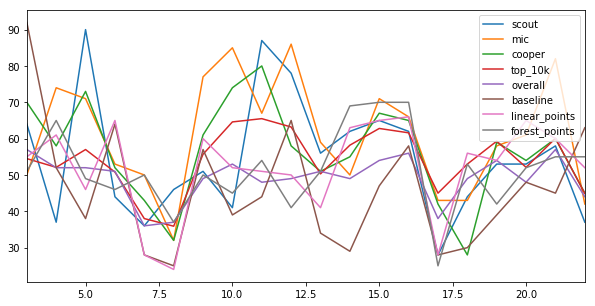

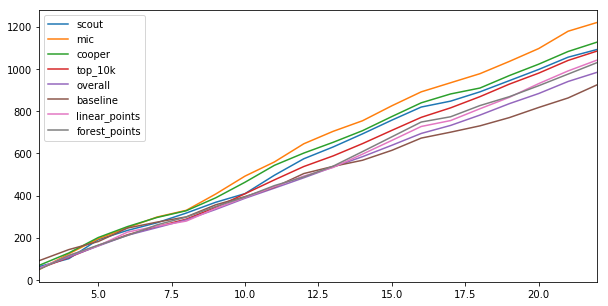

In [243]:
team_points.loc[3:22].plot(figsize=(10,5))
team_points.loc[3:22].cumsum().plot(figsize=(10,5))
team_points.loc[3:22].sum()

In [166]:
print('number of times missing bench points baseline:', number_of_alerts_baseline)
print('number of times missing bench points linear:', number_of_alerts_forest)
print('number of times missing bench points forest:', number_of_alerts_forest)

number of times missing bench points baseline: 2
number of times missing bench points linear: 2
number of times missing bench points forest: 2


In [245]:
import seaborn as sns

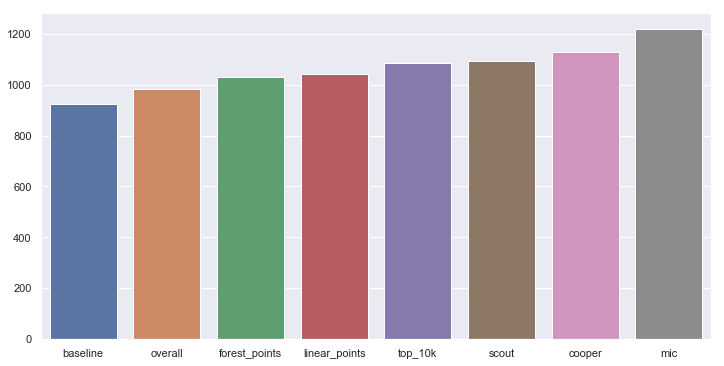

In [255]:
sums = team_points.loc[3:22].sum().sort_values()
sns.set(rc={'figure.figsize':(12, 6)})
sns.barplot(x = sums.index, y = sums)